# Kimura 4-Parameter Model with Normalized Function  
Description

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore, UniformParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm

# I added 
import math
import numpy as np
from functools import reduce
from Bio import Phylo
from io import StringIO

# create tree and initialize with noise
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList


/Users/sara/anaconda3/envs/hyperiax/bin/python


In [3]:
key = PRNGKey(42)

Kimura 2-parameters kernel function 

In [4]:
def kimura4_matrix(alpha, beta, delta, gamma):
    """
    Generates the Kimura 4-Parameter transition matrix for given alpha and beta values.

    Assume:
     i) transitions A <-> G have rate alpha,
     ii) transitions C <-> T have rate beta,
     iii) transversions to C or T have rate delta,
     iiii) transversions to A or G have rate gamma.


    Input:
        alpha: The rate of transitions A <-> G.
        beta: The rate of transitions C <-> T.
        delta: The rate of transversion to C or T.
        gamma: The rate of transversion to A or G.

    Output:
        matrix: Kimura 4-Parameter transition matrix.
    """
    # Conditions
    if alpha < 0 or beta < 0 or delta < 0 or gamma < 0:
        raise ValueError("Alpha, Beta, Delta and Gamma don't follow conditions")

    # 4x4 Transition matrix
    matrix = np.array([[1 - alpha - 2 * gamma, alpha, gamma, gamma],
                      [beta, 1 - beta - 2 * gamma, gamma, gamma],
                      [delta, delta, 1 - alpha - 2 * delta, alpha],
                      [delta, delta, beta, 1 - beta - 2 * delta]])

    # Probability Matrix rows check
    if np.all((np.sum(matrix, axis=1)) != 1):
        raise ValueError("The rows are not equal to 1")

    # print(f"kernel :\n{matrix}}")
    return matrix

In [5]:
# Update Uniform Parameter Class for updates
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

# Tree Set Up

First, we initialize the tree. We let the data be vectors in $\mathbb{R}^2$, and we set the root to be $(0,0)$.

Tree: HypTree with 5 levels and 16 nodes
     prior
       │
       x0
   ┌───┴───┐
   *       *   
 ┌─┴─┐   ┌─┴─┐ 
 *   *   *   * 
┌┴┐ ┌┴┐ ┌┴┐ ┌┴┐
A C A T C T T G


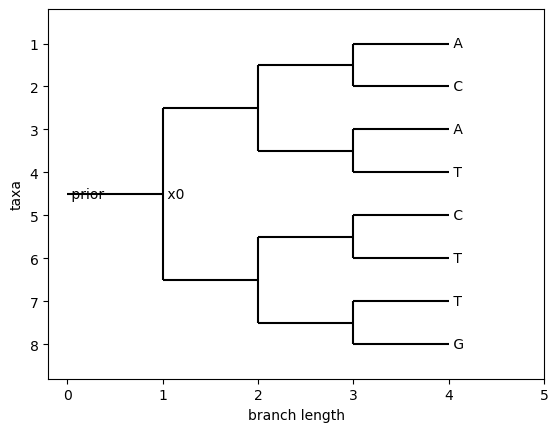

In [6]:
# create tree and initialize with noise
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList

# Initial Newick Tree
newick_string = "(((A,C), (A,T)), ((C, T), (T, G)));"
# newick = Phylo.read(StringIO(newick_string), "newick")

tree_newick = hyperiax.tree.builders.tree_from_newick(newick_string)
# tree_newick = hyperiax.tree.builders.symmetric_tree(h=5, degree=2)

# Prior Data
prior = TreeNode(); prior.name = "prior"
# Root Data
x0 = tree_newick.root; x0.name = "x0"
x0.parent = prior; prior.children = ChildList([x0])
x0.children = tree_newick.root.children

tree = HypTree(prior)
print('Tree:', tree)
tree.plot_tree_text()

# set types to select the right transitions
# types
troot = 0; tinner_node = 1; tleaf_node = 2

for i in tree.iter_bfs():
    i['type'] = tinner_node
    i['log_sum'] = 0

for i in tree.iter_leaves():
    i['type'] = tleaf_node

tree.root['type'] = troot
x0['type'] = troot
  
# number of states
R = 4

# root value
tree.root['value'] = jnp.zeros(R)

# observations, if none then random observations 
nucleotides = ['A', 'G', 'C', 'T']
for i in tree.iter_leaves():
    if i.name in nucleotides:
        i['value'] = jnp.eye(R)[nucleotides.index(i.name)]
    else:
        i['value'] = jnp.eye(R)[np.random.choice(4)]
        i.name = nucleotides[jnp.argmax(i['value'])]

Phylo.draw(Phylo.read(StringIO(tree.to_newick()), "newick"), branch_labels=lambda c: c.branch_length, do_show=False)
plt.savefig('K4_Tree.png')

# Number hidden states
for i, node in enumerate(tree.iter_bfs(), start=-1):
    node.name = f'x_{i}' if node.name is None else f'{node.name}'

# root, initial state prior
pi1 = 0.9; pi2 = 0.08; pi3 = 0.01; pi4 = 0.01
km10 = lambda params: jnp.diag([pi1, pi2, pi3, pi4])

# inner node
kst = lambda params: kimura4_matrix(params['alpha'], params['beta'], params['delta'], params['gamma'])

# leaves
lambdi = lambda params: jnp.eye(R)

# using jax.lax.cond instead of python ifs
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(kst(params), jnp.dot(lambdi(params), value)),
                                             lambda: jnp.array([pi1, pi2, pi3, pi4])
                                            )
                       )

Parameter for the transition kernel.

In [7]:
# parameters, alpha with uniform prior
params = ParameterStore({
    'alpha': UniformParameter(value=.05),  # alpha parameter for kst (Kimura)
    'beta': UniformParameter(value=.1),   # beta parameter for kst (Kimura)
    'delta': UniformParameter(value=.15),  # delta parameter for kst (Kimura)
    'gamma': UniformParameter(value=.2),  # gamma parameter for kst (Kimura)
})

true_params = ParameterStore({
    'alpha': UniformParameter(value=.05),  
    'beta': UniformParameter(value=.1),   
    'delta': UniformParameter(value=.15),  
    'gamma': UniformParameter(value=.2), 
})

We now define the backwards filter through the up function. In this case, the up operation is matrix multiplication.

In [8]:
# backwards filter. The operation is vmap'ed over the batch dimension (leading dimension)
# @jax.jit
def up(value, type, params, **args):
    return jax.vmap(lambda value, type: {'value': transition(value, type, params)})(value, type)

def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}


We create the model and executor for the backwards filter (up) in this case with the modeified product_fuse_children to normalize the values after joining them.

In [9]:
# create model and executor
save_tree = tree.copy()
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

We are now ready to execute the upwards pass.

In [10]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# It also normalizes the prior right now so
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3, pi4])

# print results
total_log_sum = 0
for node in utree.iter_bfs():
    #print(node.name)
    print(node.data)
    total_log_sum += node.data['log_sum']
    

{'type': 0, 'log_sum': 0, 'value': Array([0.9 , 0.08, 0.01, 0.01], dtype=float32)}
{'type': 0, 'log_sum': -0.9686181649438849, 'value': Array([0.5737892 , 0.4415685 , 0.28500563, 0.6281362 ], dtype=float32)}
{'type': 1, 'log_sum': -0.9908570220387302, 'value': Array([0.85522497, 0.22144218, 0.30351081, 0.3569801 ], dtype=float32)}
{'type': 1, 'log_sum': -0.8772693209788401, 'value': Array([0.25597054, 0.60153073, 0.18765838, 0.7330921 ], dtype=float32)}
{'type': 1, 'log_sum': -1.9031281253919745, 'value': Array([0.7377526 , 0.13413684, 0.6539171 , 0.10060263], dtype=float32)}
{'type': 1, 'log_sum': -1.9398686105372263, 'value': Array([0.7653621 , 0.13915674, 0.05218378, 0.6262053 ], dtype=float32)}
{'type': 1, 'log_sum': -2.4232228605771984, 'value': Array([0.4512865 , 0.4512865 , 0.36667025, 0.6769297 ], dtype=float32)}
{'type': 1, 'log_sum': -2.001623845503902, 'value': Array([0.07401065, 0.74010646, 0.05550799, 0.66609585], dtype=float32)}
{'type': 2, 'log_sum': 0, 'value': Array([1

# Likelihood Computation

In [11]:
# Compute Log-Likelihood
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The log-likelihoog is {log_lik}")

The log-likelihoog is -11.682859195054583


# Parameters Comparation

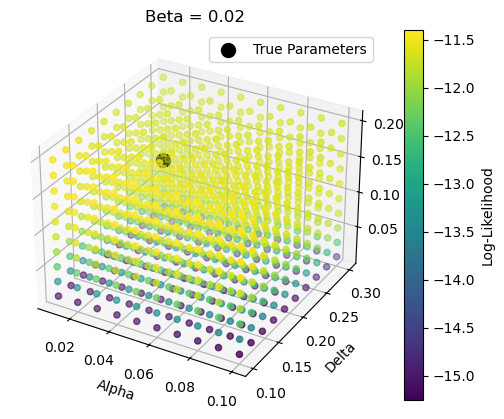

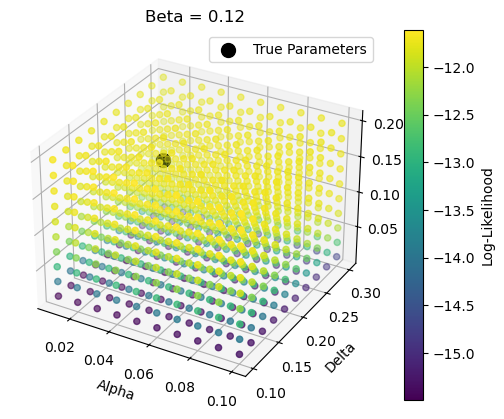

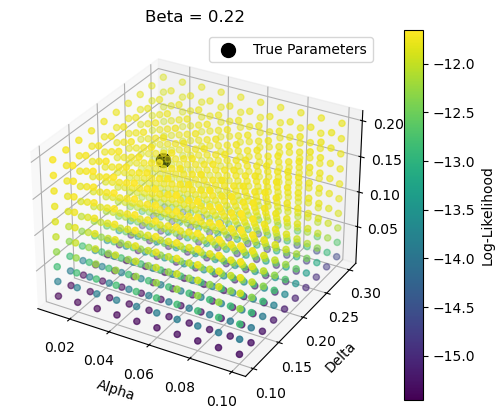

In [13]:
# Define the ranges for the parameters

alpha_range = np.linspace(0.01, 0.1, 10)
delta_range = np.linspace(0.1, 0.3, 10)
gamma_range = np.linspace(0.01, 0.2, 10)

beta_values = [0.02, 0.12, 0.22]

# Create a 3D grid of parameter values for each beta
alpha_grid, delta_grid, gamma_grid = np.meshgrid(alpha_range, delta_range, gamma_range, indexing='ij')

for idx, beta in enumerate(beta_values):
    # Compute the log-likelihoods for each parameter combination
    likelihoods = np.zeros((len(alpha_range), len(delta_range),len(gamma_range)))
    params['beta'].update(float(beta), True)
    
    for i, new_alpha in enumerate(alpha_range):
        for j, new_delta in enumerate(delta_range):
            for k, new_gamma in enumerate(gamma_range):
                # Update the parameters
                params['alpha'].update(float(new_alpha), True)
                params['delta'].update(float(new_delta), True)
                params['gamma'].update(float(new_gamma), True)
                
                # create model and executor
                upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
                upexec = LevelwiseTreeExecutor(upmodel)
                
                # execture backwards filter
                new_tree = upexec.up(tree, params.values())
                
                # It also normalizes the prior right now so
                new_tree.root.data['log_sum'] = 0

                # print results
                total_log_sum = 0
                for node in utree.iter_bfs():
                    total_log_sum += node.data['log_sum']
            
                # Compute Log-Likelihood
                h0_vec = new_tree.root.children[0].data['value']
                new_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
                likelihoods[i, j, k] = new_lik 
                
    # Plot for each gamma
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(alpha_grid.flatten(), delta_grid.flatten(), gamma_grid.flatten(), c=likelihoods.flatten(),cmap='viridis')

    ax.scatter(true_params['alpha'].value, true_params['delta'].value, true_params['gamma'].value, color='black', s=100, label='True Parameters')

    ax.set_title(f'Beta = {beta:.2f}')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Delta')
    ax.set_zlabel('Gamma')
    fig.colorbar(sc, ax=ax, label='Log-Likelihood')
    ax.legend()
    plt.savefig(f"K4_Contour{beta:.2f}.png")
    plt.show()